<a href="https://colab.research.google.com/github/akitim/SkillFactory_projects/blob/main/Project_5_SF_Scoring_Akimkin_Timofey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Итоговый проект по Юниту 5 "Компьютер говорит <<Нет>>" Акимкина Тимофея**

---
## **1. Загрузка библиотек**
---
---

In [36]:
import numpy as np # linear algebra
import pandas as pd 
import pandas_profiling # автоматизация EDA

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns # импорт графических библиотек

from sklearn import metrics as mt # импорт метрик модели

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

---
## **2. Загрузка данных**
---
---

In [37]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [38]:
# DATA_DIR = '/kaggle/input/sf-scoring/'
# DATA_DIR = '/content/sample_data'

DATA_DIR = 'https://raw.githubusercontent.com/akitim/datasets/main/Project%205/'

df_train = pd.read_csv(DATA_DIR +'/train.csv')
df_test = pd.read_csv(DATA_DIR +'/test.csv')
# sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

---
## **3. Первичный осмотр данных**
---
---

In [39]:
# sample_submission.sample(5)

In [40]:
# sample_submission.shape

In [41]:
# sample_submission.info()

In [42]:
df_test.shape

(36349, 18)

---
## **4. EDA**
---
---

In [43]:
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [44]:
# для корректной обработки признаков объединяем
# тренировочную и тестовую выборки в один датасет

df_train['sample'] = 1 # помечаем, где у нас тренировочные данные
df_test['sample'] = 0  # помечаем, где у нас тестовые данные
df_test['default'] = 0 # в тесте у нас нет значения default,
# мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем train и test

In [45]:
# ===============================================================================
# Построение множественных графиков

def draw_charts_for_numeric(data, target='default', plot_type='histplot',
                charts_in_row=3, \
                title='Распределение числовых переменных и их логарифмов\n',\
                fs=(20,20),\
                **kwargs):
    
    def chart_to_plot(data_, col, tgt, plt_fun, ax_c, is_log=False): # выбор типа графика 
 
        d = data_.dropna().copy()

        if is_log:
            d[col] = d[col].apply(lambda x: np.log(x + 1))
            
        if plt_fun == 'histplot':
            sns.histplot(d[col], kde=True, ax=ax_c)
        elif plt_fun == 'boxplot':
            sns.boxplot(x=tgt, y=col, data=d, ax=ax_c)
            ax_c.set_xlabel(col, fontsize=13)
    
    n_feat_to_plot = data.shape[1] - 1

    fig, ax = plt.subplots((n_feat_to_plot // charts_in_row + 1) * 2, charts_in_row, sharey=False, figsize=fs)
    fig.suptitle(title, fontsize=20);

    for i, feat in enumerate(data.columns): # строим графики
        
        ax_curr = ax[2 * (i // 3), i % 3]    
        
        # график переменной
        chart_to_plot(data_=data, tgt=target, col=feat, plt_fun=plot_type, ax_c=ax_curr)
        
        ax_curr.set_title(feat)
        ax_curr.set_xlabel('')
        ax_curr.set_ylabel('')
        
        if feat==target: fig.delaxes(ax_curr)
            
        ax_curr = ax[2 * (i // 3) + 1, i % 3]    
        
        # график логарифма переменной
        chart_to_plot(data_=data, tgt=target, col=feat, plt_fun=plot_type, is_log=True, ax_c=ax_curr)
        
        ax_curr.set_title(f'log({feat})')
        ax_curr.set_xlabel('')
        ax_curr.set_ylabel('')
        
        if feat==target: fig.delaxes(ax_curr)

    # удаляем пустые графики
    for axes in ax.flatten():
        if not(axes.has_data()):
            fig.delaxes(axes)

Посмотрим распределение числовых признаков и их логарифмов

In [46]:
# draw_charts_for_numeric(data=df_test[num_cols], plot_type='histplot', charts_in_row=3, \
#                 title='\n\n\nРаспределение числовых переменных и их логарифмов\nв тестовых данных',\
#                 fs=(15, 20))

# draw_charts_for_numeric(data=df_train[num_cols+['default']], plot_type='histplot', charts_in_row=3, \
#                 title='\n\n\nРаспределение числовых переменных и их логарифмов\nв тренировочных данных',\
#                 fs=(15, 20))

# draw_charts_for_numeric(data=df_train[num_cols+['default']], plot_type='boxplot', charts_in_row=3, \
                # title='\n\n\nРаспределение числовых переменных и их логарифмов\nв тренировочных данных',\
                # fs=(15, 20))

> **Вывод:** распределения числовых признаков в тестовой и тренировочной в целом идентичны (визуально).

In [47]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [48]:
# df_test.info()

> **Вывод:** есть пропуски в признаке education

In [49]:
df_train.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
21906,93101,09APR2014,UGR,F,27,N,N,1,1,-1.482142,1,60,2,3,20000,4,3,Y,0,1
2755,41960,18FEB2014,SCH,F,42,N,N,0,0,-2.164592,0,50,1,2,15000,1,4,N,0,1
62542,2432,08JAN2014,GRD,F,54,N,N,0,0,-1.133494,6,60,1,2,65000,2,3,N,0,1
7261,46411,22FEB2014,SCH,F,32,N,N,0,0,-2.591076,2,40,1,2,15000,1,4,N,0,1
57031,84125,01APR2014,UGR,F,33,N,N,0,1,-1.765385,0,40,2,3,11000,4,3,N,1,1


In [50]:
# pandas_profiling.ProfileReport(df_train)

In [51]:
data.nunique(dropna=False)

client_id           110148
app_date               120
education                6
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
sample                   2
default                  2
dtype: int64

In [52]:
old_cols = set(['client_id', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'bki_request_cnt', 'home_address',
       'work_address', 'income', 'foreign_passport', 'default'])

new_cols = set(df_train.columns) - old_cols - set(['sample'])
print ('Новые признаки:\n', *new_cols)

Новые признаки:
 sna score_bki app_date region_rating first_time


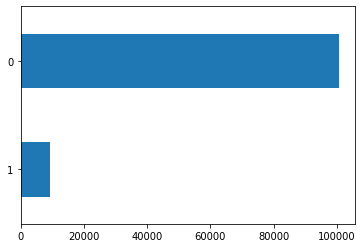

In [53]:
data['default'].value_counts(ascending=True).plot(kind='barh');

Наблюдается сильный дисбаланс классов: <br> 

In [54]:
print('соотношение недефолтных клиентов к дефолтным - 1 к',\
      round(data.default[data.default == 0].count() / data.default[data.default == 1].count()))

соотношение недефолтных клиентов к дефолтным - 1 к 11


---
#### Заполнение пропусков
---
---

##### Заполняем пропуски в `education` случайным образом так, чтобы распределение признака не поменялось

In [55]:
edu_species = data['education'].dropna().unique()
edu_species_num = edu_species.shape[0]

#доля каждого значения среди всех значений признака education

weights = data[data['sample']==1]['education'].value_counts() / \
    data[data['sample']==1]['education'].count()

data['education'] = data['education'].apply(
    lambda x: np.random.choice(edu_species, 1, p = weights)[0] if pd.isna(x) else x
)

In [56]:
# копируем датасет для альтернативной обработки признаков с помощью WoE

data_for_WoE = data.copy()

---
### **Обработка признаков**
---
---



##### Логарифмирование признаков

In [57]:
#логарифмируем все числовые признаки кроме score_bki

cols_to_log = num_cols.copy()
cols_to_log.remove('score_bki')

# x + 1 - избегаем взятия логарифма от нуля

data[cols_to_log] = data[cols_to_log].apply(lambda x: np.log(x + 1))

##### Выявление выбросов


In [58]:
train_data = data.query('sample == 1')[num_cols]

#вычисляем 1й и 3й квартили и межквартильный интервал для тренировочного датасета
Q1 = train_data.quantile(0.25, axis=0)
Q3 = train_data.quantile(0.75, axis=0)

IQR = Q3 - Q1
lbound, ubound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

outliers = {}
for col in num_cols:

    outliers[col] = [data[(~data[col].between(lbound[col], ubound[col])) &
                              (data.default == 1)][col].count(),
                      
                     data[(~data[col].between(lbound[col], ubound[col])) &
                              (data.default == 0)][col].count(),
                    ]
    
    outliers[col] += [sum(outliers[col])]

outliers = pd.DataFrame(outliers, index=pd.MultiIndex.from_product([
                                    ['outliers'],
                                    ['default = 1',
                                     'default = 0',
                                     'total']]),
)

num_cols_w_outliers = \
    outliers.loc[
                 ('outliers', 'total'),
                 outliers.loc[('outliers', 'total'), :] != 0
    ].index
print ('\033[1m' + '===============================  ВЫБРОСЫ  ==================================' + '\033[0m\n')
display(outliers)

===============================  ВЫБРОСЫ  ==================================



age  score_bki  decline_app_cnt  bki_request_cnt  income
outliers default = 1    0        114             2667                4     177
         default = 0    0        421            16010               11    2432
         total          0        535            18677               15    2609

##### Добавляем новые признаки на основе выбросов

***Описание добавить***


In [59]:
for col in num_cols_w_outliers:

    # создаем новый признак
    data[col + '_outliers'] = 0

    # маски для "верхних" и "нижних" выбросов
    mask_right = data[col] >= ubound[col]
    mask_left = data[col] <= lbound[col]

    data.loc[mask_right | mask_left, col + '_outliers'] = \
        outliers.loc[('outliers', 'total'), col]

    # подтягиваем выбросы к краям интервала с невыбросными значениями
    data.loc[mask_right, col] = ubound[col]
    data.loc[mask_left,  col] = lbound[col]

##### Label и One-Hot encoding

In [60]:
# удаляем заведомо не влияющие признаки
data.drop(['client_id','app_date',], axis = 1, inplace=True)

In [61]:
data = pd.get_dummies(data, columns=['education'], dummy_na=False)

In [62]:
from sklearn import preprocessing as pp

label_enc = pp.LabelEncoder()

for col in bin_cols:
    data[col] = label_enc.fit_transform(data[col])
    
cat_cols_copy = cat_cols.copy()
cat_cols_copy.remove('education')

for col in cat_cols_copy:
    data[col] = label_enc.fit_transform(data[col])

In [63]:
data.sample(5)

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,score_bki_outliers,decline_app_cnt_outliers,bki_request_cnt_outliers,income_outliers,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR
64693,0,3.433987,0,0,0.0,0,-1.546527,1.386294,4,0,1,10.668979,0,3,1,1,0,0,18677,0,0,0,1,0,0,0
36303,1,3.610918,1,1,0.0,0,-1.968694,0.693147,4,0,0,11.512935,0,2,0,0,0,0,18677,0,0,0,1,0,0,0
21676,1,3.737670,0,0,0.0,0,-1.908590,1.098612,2,1,2,10.043293,1,2,0,0,0,0,18677,0,0,0,1,0,0,0
82959,0,3.737670,1,0,0.0,0,-1.915393,0.000000,3,0,1,8.590378,0,3,0,1,0,0,18677,0,2609,0,1,0,0,0
56385,0,3.637586,0,0,0.0,0,-2.868188,0.000000,4,0,1,9.615872,0,3,0,1,0,0,18677,0,0,0,1,0,0,0


##### Стандартизация признаков

*стандартизируем объединенный датасет data по параметрам тренировочной выборки*

In [64]:
r_scaler = pp.RobustScaler() #pp.StandardScaler()

r_scaler.fit(data[data['sample'] == 1].drop(['sample', 'default'], axis=1))

cols_for_scaling = list(data.columns)
cols_for_scaling.remove('default')
cols_for_scaling.remove('sample')

data[cols_for_scaling] = r_scaler.transform(data.drop(['sample', 'default'], 
                                                        axis=1))

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   sex                       110148 non-null  float64
 1   age                       110148 non-null  float64
 2   car                       110148 non-null  float64
 3   car_type                  110148 non-null  float64
 4   decline_app_cnt           110148 non-null  float64
 5   good_work                 110148 non-null  float64
 6   score_bki                 110148 non-null  float64
 7   bki_request_cnt           110148 non-null  float64
 8   region_rating             110148 non-null  float64
 9   home_address              110148 non-null  float64
 10  work_address              110148 non-null  float64
 11  income                    110148 non-null  float64
 12  sna                       110148 non-null  float64
 13  first_time                110148 non-null  f

In [66]:
data.sample(5)

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,score_bki_outliers,decline_app_cnt_outliers,bki_request_cnt_outliers,income_outliers,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR
38648,0.0,0.218602,0.0,0.0,0.0,0.0,0.954576,-0.5,0.0,-1.0,-1.0,-0.791732,3.0,-1.0,0.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19421,1.0,0.599426,1.0,1.0,0.0,0.0,-0.414953,-0.5,1.0,0.0,0.0,0.176078,2.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18623,1.0,-0.667015,1.0,1.0,0.0,1.0,-0.620015,0.0,-1.0,-1.0,0.0,0.328605,0.0,0.5,0.0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0
64614,0.0,0.417303,1.0,1.0,0.0,1.0,-0.643574,-0.5,1.0,-1.0,-1.0,0.583492,0.0,0.0,0.0,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0
60774,1.0,1.104220,1.0,1.0,0.0,0.0,-0.527138,0.0,2.0,-1.0,0.0,1.912124,0.0,0.0,0.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0


---
### **Альтернативная обработка и анализ признаков с помощью WoE и IV**
---
---


In [67]:
# выделим тренировочную и тестовую часть из объединенного датасета
# и удалим неинформативные признаки

train_data_for_WoE = data_for_WoE.query('sample == 1'). \
    drop(['sample', 'client_id', 'app_date'], axis=1)

test_data_for_WoE = data_for_WoE.query('sample == 0'). \
    drop(['sample', 'client_id', 'app_date'], axis=1)

train_data_for_WoE.sample(5)

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
67908,GRD,F,32,Y,N,1,0,-1.025934,1,60,2,3,20000,1,2,N,0
39016,GRD,M,32,Y,Y,0,0,-2.666880,0,50,1,2,150000,1,1,N,0
107930,UGR,M,25,N,N,1,0,-2.211330,1,60,1,2,30000,3,2,N,0
57359,GRD,M,42,Y,Y,0,0,-1.501692,2,80,2,3,80000,2,3,Y,0
41833,GRD,M,26,N,N,2,1,-1.256334,5,60,2,3,25000,1,1,N,0


In [68]:
# ==============================================================================
# Категоризация числовых переменных (разбиением на интервалы).
# Вычисление характеристик Weight of Evidence и Information Value

# Принимает:
# data - DataFrame; входные данные, 
# target - str; имя целевой бинарной переменной: {0, 1}
# bins - int; число интервалов, на которое делится диапазон значений переменной;
#        каждый интервал содержит приблизительно 1 / bins от всех значений признака

# Возвращает:
# tuple: (DataFrame, DataFrame)
# Значения WoE по всем числовым переменным и всем категориальным, значения IV по всем переменным.

def WoE_IV_calc(data, target, bins=10):
    
    WoE_df = pd.DataFrame()

    columns = data.columns
    cat_cutoff = 10 # порог для определения категориальных переменных:
    # если значений в переменной < 10 - считаем ее категориальной

    for col in columns[~columns.isin([target])]:

        if data[col].dtype.kind in 'bif' and len(data[col].unique()) > cat_cutoff:
            data_binned = pd.qcut(data[col], bins, duplicates='drop', retbins=False)
        else:
            data_binned = data[col]

        data_binned = pd.DataFrame(data_binned)
        data_binned[target] = data[target]
        
        df = pd.concat(
            [data_binned.loc[data_binned[target] == 1, col].
                value_counts().sort_index(),
            data_binned.loc[data_binned[target] == 0, col].
                value_counts().sort_index()], axis=1
        )
        
        df = df.reset_index()
        df.columns = ['category', 'pos', 'neg']

        df['N'] = df['neg'] + df['pos']
        df['% pos'] = df['pos'] / df['pos'].sum() * 100
        df['% neg'] = df['neg'] / df['neg'].sum() * 100
        df['WoE'] = np.log(df['% neg'] / df['% pos'])
        df['IV'] = (df['% neg'] - df['% pos']) / 100 * df['WoE']

        total = pd.DataFrame(df.iloc[:, 1:].sum(axis=0)).T
        total.insert(loc=0, column='category', value='total for ' + col)

        df = df.append(total, ignore_index=True)
        df.insert(loc=0, column='variable', value=col)

        WoE_df = pd.concat([WoE_df, df], axis=0)

    IV_df = WoE_df[WoE_df['category'].
        apply(lambda s: 'total' in s if type(s)==str else False)]
    IV_df = IV_df[['variable', 'IV']].sort_values(by='IV', ascending=False) \
        .reset_index(drop=True)

    return WoE_df, IV_df

# ==============================================================================
# Сопоставляет значение переменной WoE.

# Принимает:
# value - float; значение для сопоставления
# WoE - DataFrame; датафрейм, рассчитываемый функцией WoE_IV_calc

# Возвращает:
# float, int или str; значение WoE

def value2WoE(value, WoE):
    return WoE.loc[(WoE['category'].apply(
                lambda x: value in x
                    if type(x) == pd._libs.interval.Interval
                    else x == value)), 'WoE'].values[0]

# ==============================================================================
# Преобразует переменные в значения WoE.

# Принимает:
# data - float; датафрейм для преобразования, переменные записаны в столбцах
# WoE - DataFrame; датафрейм, рассчитываемый функцией WoE_IV_calc

# Возвращает:
# DataFrame; преобразованный датафрейм.

def cast_WoE_on_df(data, WoE):
    data_ = data.copy()
    return data_.apply(
        lambda col: col.apply(
            lambda x: value2WoE(x, WoE[WoE['variable']==col.name])
            )
        )

Посмотрим на монотонность WoE категоризированных числовых переменных:

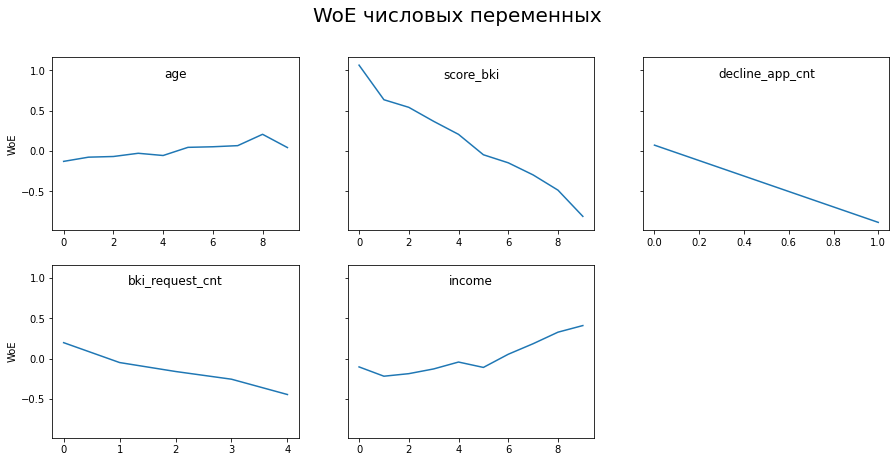

In [69]:
WoE, IV = WoE_IV_calc(train_data_for_WoE, 'default', bins=10)
   
fig, ax = plt.subplots(2, 3, figsize=(15,7), sharey=True)
fig.suptitle('WoE числовых переменных', fontsize=20);
ax = ax.ravel()


# строим графики WoE для всех переменных
for i, col in enumerate(num_cols):
    sns.lineplot(data=WoE[WoE['variable']==col].iloc[:-1, -2], 
                 ax=ax[i]
    );
    ax[i].set_title(col, y=0.85)

# удаляем пустые графики
for axes in ax:
    if not(axes.has_data()):
        fig.delaxes(axes)

**Вывод:** WoE переменных вполне монотонны, следовательно, разбиение переменных на интервалы хорошее.

Проранжируем признаки по Information Value

Воспользуемся следующей трактовкой предсказательной мощности диапазонов IV: $\ ^1$ 

$\ IV \ range $          | Predictive power 
-------------------------| ---------------------- 
$$\ (-\infty, \ 0.02] $$ | Not useful 
$$\ (0.02,    \  0.1] $$ | Weak
$$\ (0.1,     \  0.3] $$ | Medium
$$\ (0.3,     \  0.5] $$ | Strong
$$\ (0.5, \   \infty) $$ | Suspicious

$\ ^1 $ *Siddiqi, N. (2006). Credit Risk Scorecards*



In [70]:
# предиктивная мощность IV
IV_pred_range = pd.Series({
    'Not useful': pd.Interval(-np.Infinity, 0.02),
    'Weak': pd.Interval(0.02, 0.1),
    'Medium': pd.Interval(0.1, 0.3),
    'Strong': pd.Interval(0.3, 0.5),
    'Suspicious': pd.Interval(0.5, np.Infinity, closed='neither')
})

IV['power'] = ''
for row in range(IV.shape[0]):
    IV.loc[row, 'power'] = \
        IV_pred_range[IV_pred_range.apply(lambda x: IV.loc[row, 'IV'] in x)].index[0]

display (IV)

,variable,IV,power
0,score_bki,0.275214,Medium
1,sna,0.132047,Medium
2,first_time,0.101243,Medium
3,region_rating,0.081816,Weak
4,home_address,0.079869,Weak
5,education,0.072018,Weak
6,work_address,0.067363,Weak
7,decline_app_cnt,0.065325,Weak
8,foreign_passport,0.048587,Weak
9,bki_request_cnt,0.044567,Weak


### Визуализируем распределение IV по признакам датасета

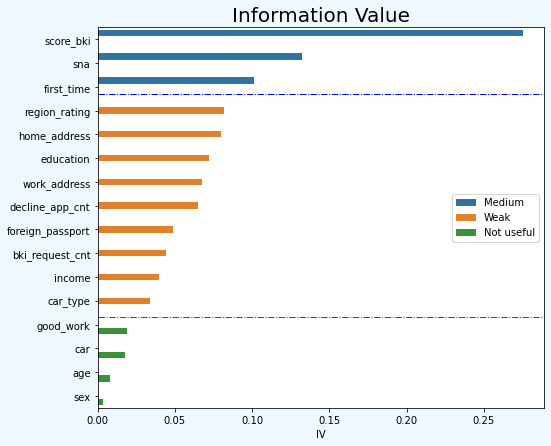

In [149]:
plt.figure(figsize=(8,7), facecolor='aliceblue')
ax = sns.barplot(x=IV['IV'], y=IV['variable'], hue=IV['power']);
ax.set_title('Information Value', fontsize='20');
ax.set_ylabel('');
plt.axhline(y=11.7, color="green", linestyle="-.", linewidth=1);
plt.axhline(y=2.3, color="blue", linestyle="-.", linewidth=1);
ax.legend(loc='center right');

In [ ]:
# отберем для модели признаки со средней и слабой предсказательной силой

predict_cols = IV[IV['power'].isin(['Weak', 'Medium'])]['variable'].values
predict_cols

array(['score_bki', 'sna', 'first_time', 'region_rating', 'home_address',
       'education', 'work_address', 'decline_app_cnt', 'foreign_passport',
       'bki_request_cnt', 'income', 'car_type'], dtype=object)

In [ ]:
# признаки на удаление из обучающего датасета

cols_to_drop = list(set(train_data_for_WoE.columns) - set(predict_cols) - {'default'})
cols_to_drop

['good_work', 'sex', 'age', 'car']

In [ ]:
 # удаляем признаки
 train_data_for_WoE.drop(cols_to_drop, axis=1, inplace=True)
 test_data_for_WoE.drop(cols_to_drop + ['default'], axis=1, inplace=True)

In [ ]:
# преобразуем тренировочную часть к WoE
train_data_for_WoE[predict_cols] = \
    cast_WoE_on_df(train_data_for_WoE[predict_cols], WoE)
# выполнение 12 мин 19 сек

In [ ]:
# train_data_for_WoE = pd.read_csv('train_data_for_WoE_v1.csv')

train_data_for_WoE.sample(5)

,education,car_type,decline_app_cnt,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
77465,0.382754,-0.081082,0.074362,-0.044779,0.198768,-0.340062,-0.233006,-0.177091,0.328874,0.289570,0.062081,-0.081641,0
63605,0.382754,-0.081082,-0.883227,-0.808856,0.198768,0.356462,-0.233006,-0.177091,0.055057,0.289570,0.062081,-0.081641,1
72338,0.382754,-0.081082,0.074362,0.369722,0.198768,0.611418,-0.233006,-0.177091,0.185791,0.289570,0.062081,-0.081641,0
40942,0.382754,-0.081082,0.074362,-0.483772,-0.047670,-0.340062,0.350976,0.241872,-0.126872,-0.252005,0.062081,-0.081641,0
49960,-0.196965,-0.081082,0.074362,-0.294768,0.198768,-0.080085,0.350976,0.241872,-0.185553,-0.191802,0.062081,-0.081641,1


In [ ]:
test_data_for_WoE[predict_cols] = \
    cast_WoE_on_df(test_data_for_WoE[predict_cols], WoE)
# 6 мин 7 сек

In [ ]:
# test_data_for_WoE = pd.read_csv('test_data_for_WoE_v1.csv')

test_data_for_WoE.sample(5)

,education,car_type,decline_app_cnt,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
149,-0.196965,-0.081082,0.074362,0.637435,0.198768,-0.016495,0.350976,0.241872,-0.217095,0.289570,0.062081,-0.081641
14972,0.382754,-0.081082,0.074362,-0.808856,-0.047670,-0.080085,-0.233006,-0.177091,-0.041456,0.289570,-0.235165,-0.081641
29802,-0.196965,-0.081082,0.074362,-0.483772,-0.047670,-0.016495,-0.233006,-0.177091,-0.041456,0.289570,0.487271,-0.081641
31121,-0.196965,0.417369,0.074362,1.066220,-0.047670,-0.016495,0.350976,0.241872,0.410849,-0.191802,0.487271,-0.081641
25692,0.382754,-0.081082,-0.883227,0.637435,0.198768,0.356462,-0.233006,-0.177091,0.185791,0.289570,0.062081,-0.081641


ЗАПИСЬ ТРАНСФОРМИРОВАННЫХ К WOE TRAIN И TEST В ФАЙЛ 

In [ ]:
train_data_for_WoE.to_csv('train_data_for_WoE_v2.csv', index=False)
test_data_for_WoE.to_csv('test_data_for_WoE_v2.csv', index=False)

---
## **5. Построение модели**
---
---

In [ ]:
class ModelMetrics:
# =======================================================================
# Класс для визуализации метрик модели

# =======================================================================
# Инициализация объекта

    def __init__(self, y_true, y_pred, y_proba):
        self.y_true = y_true
        self.y_pred = y_pred
        self.y_proba = y_proba

# =======================================================================
# Визуализация кривой Receiver Operating Characteristic

    def plot_roc_curve(self, model_label='Модель'):

        from sklearn.metrics import roc_auc_score, roc_curve

        roc_auc = roc_auc_score(self.y_true, self.y_proba)
        FPR, TPR, THRESHOLDS = roc_curve(self.y_true, self.y_proba)

        plt.figure(figsize=(8,5))
        plt.plot([0, 1], label='''"Наивный" классификатор''', linestyle='-.')
        plt.plot(FPR, TPR, label ='Вид модели: ' + model_label)
        plt.title(f"\nКривая ROC (ROC's AUC =  {roc_auc:0.3f})", fontsize=18)
        plt.ylabel('Доля истинноположительных предсказаний\n(True Positive Rate)')
        plt.xlabel('Доля ложноположительных предсказаний\n(False Positive Rate)')
        plt.legend(loc = 'upper left')
        plt.show()

# =======================================================================
# Визуализация кривой  Точность - Полнота (Precision - Recall) 
# с расчетом метрики площади под кривой (метрика ROC's AUC)

    def plot_precision_recall_curve(self, model_label='Модель'):

        from sklearn.metrics import precision_recall_curve

        prec, rec, thresholds = precision_recall_curve(self.y_true, self.y_proba)
        
        AUC = 0.5 * (rec[:-1] - rec[1:]) @ (prec[:-1] + prec[1:])

        baseline = self.y_true[self.y_true==1].shape[0] / self.y_true.shape[0]

        plt.figure(figsize=(8,5))
        plt.plot([baseline, baseline], label='''"Наивный" классификатор''', linestyle='-.')
        plt.plot(rec, prec, label = 'Вид модели: ' + model_label)

        plt.title(f"\n\nКривая Precision - Recall (PR's AUC =  {AUC:0.3f})", fontsize=18)
        plt.ylabel('Точность\n(Precision)', fontsize=13)
        plt.xlabel('Полнота\n(Recall)', fontsize=13)
        plt.legend(loc = 'upper right')
        plt.show()

# =======================================================================
# Вывод основных метрик модели в виде таблицы

    def print_metrics(self):

        from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score,\
            precision_score, recall_score, roc_auc_score
        
        metrics_ = {'Accuracy': [accuracy_score(self.y_true, self.y_pred)],
                    'Balanced accuracy': [balanced_accuracy_score(self.y_true, self.y_pred)],
                    'Precision':  [precision_score(self.y_true, self.y_pred)],
                    'Recall': [recall_score(self.y_true, self.y_pred)],
                    'F1-score': [f1_score(self.y_true, self.y_pred)],
                    "ROC's AUC": [roc_auc_score(self.y_true, self.y_proba)]}

        print('\n\n' + '\033[1m' + \
              '===============================  МЕТРИКИ  ==============================' + \
              '\033[1m\n')
        display(pd.DataFrame(metrics_, index=['']))
        return None

# =======================================================================
# Визуализация матрицы ошибок

    def conf_matrix_visual(self):

        from sklearn.metrics import confusion_matrix

        ax = sns.heatmap(confusion_matrix(self.y_true, self.y_pred),
                    annot=True, fmt='.0f', linewidth=2, cmap='Blues',
                    annot_kws={'size': 20},
                    xticklabels=['Не дефолт', 'Дефолт'],
                    yticklabels=['Не дефолт', 'Дефолт']
                    )
        
        ax.tick_params(left=False, bottom=False) # удаляем штрихи

        annot_labels = ['TN', 'FP', 'FN', 'TP']
        for i, t in enumerate(ax.texts):
            t.set_text(annot_labels[i] + '\n' + t.get_text())
        
        ax.set_xlabel(r'$\ Предсказанные $', fontsize=18, color= '#01153E',
                      labelpad=20, weight='bold', rotation = 0)
        ax.set_ylabel(r'$\ Истинные $', fontsize=18, color='#01153E',
                      labelpad=25, rotation = 90)
        
        plt.xticks(rotation=-45, fontsize=11, weight='bold')
        plt.yticks(rotation=45, fontsize=11, weight='bold')

        plt.title('\nМатрица ошибок\n', fontsize=20)
        return None

In [ ]:
# Выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)

y = train_data['default'].values  # наш таргет
X = train_data.drop(['default'], axis=1)

In [ ]:
# Воспользуемся функцией train_test_split для разбивки тестовых данных
from sklearn.model_selection import train_test_split

# выделим 20% данных на валидацию
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# test_data.columns

In [ ]:
# X_train.columns

In [ ]:
# X_valid.columns

In [ ]:
# проверяем
# test_data.shape, train_data.shape, X.shape, X_train.shape, X_valid.shape

##### Логистическая регрессия

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear', max_iter=1000,
                            class_weight='balanced',
                            fit_intercept=True,
                            random_state=RANDOM_SEED)

logreg.fit(X_train, y_train)

y_proba = logreg.predict_proba(X_valid)[:, 1]
y_pred = logreg.predict(X_valid)

Метрики для логистической регрессии

In [ ]:
model_metrics = ModelMetrics(y_valid, y_pred, y_proba)



===============================  МЕТРИКИ  ==============================



,Accuracy,Balanced accuracy,Precision,Recall,F1-score,ROC's AUC
,0.659282,0.666213,0.217637,0.675424,0.329198,0.73484


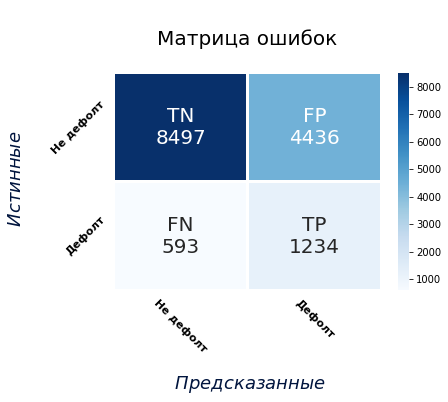

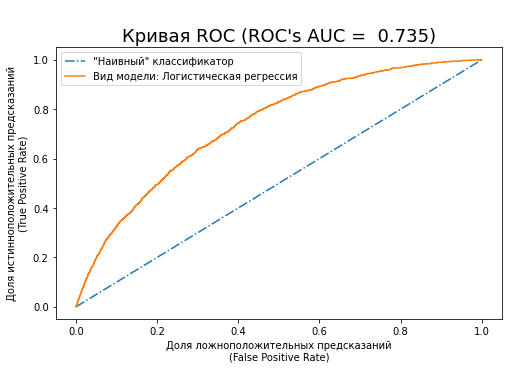

In [ ]:
model_metrics.print_metrics()
model_metrics.conf_matrix_visual()
model_metrics.plot_roc_curve(model_label='Логистическая регрессия')

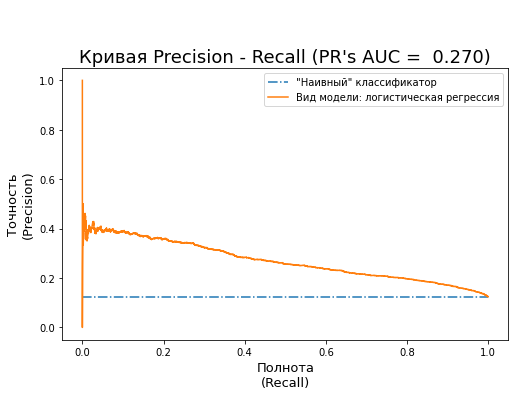

In [ ]:
model_metrics.plot_precision_recall_curve(model_label='логистическая регрессия')

##### Логистическая регрессия ***с WoE***

In [ ]:
y = train_data_for_WoE['default'].values  # наш таргет
X = train_data_for_WoE.drop(['default'], axis=1)

# выделим 20% данных на валидацию
X_train_WoE, X_valid_WoE, y_train_WoE, y_valid_WoE =\
    train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# params_WoE = {
#     'C'= 0.01778279410038923,
# 	'class_weight'= 'balanced',
# 	'dual'= False,
# 	'fit_intercept'= True,
# 	'intercept_scaling'= 1,
# 	'l1_ratio'= None,
# 	'max_iter'= 1000,
# 	'multi_class'= 'ovr',
# 	'n_jobs'= None,
# 	'penalty'= 'l1',
# 	'random_state'= RANDOM_SEED,
# 	'solver'= 'liblinear',
# 	'tol'= 1e-05,
# 	'verbose'= 0,
# 	'warm_start'= False
# }
# logreg_WoE = LogisticRegression(solver='liblinear', max_iter=1000,
#                             class_weight='balanced',
#                             fit_intercept=True,
#                             random_state=RANDOM_SEED)

logreg_WoE = LogisticRegression(
    C= 0.01778279410038923,
	class_weight= 'balanced',
	dual= False,
	fit_intercept= True,
	intercept_scaling= 1,
	l1_ratio= None,
	max_iter= 1000,
	multi_class= 'ovr',
	n_jobs= None,
	penalty= 'l1',
	random_state= RANDOM_SEED,
	solver= 'liblinear',
	tol= 1e-05,
	verbose= 0,
	warm_start= False
)

logreg_WoE.fit(X_train_WoE, y_train_WoE)

y_proba_WoE = logreg_WoE.predict_proba(X_valid_WoE)[:, 1]
y_pred_WoE = logreg_WoE.predict(X_valid_WoE)

Метрики для логистической регрессии ***с WoE***

In [ ]:
model_metrics_WoE = ModelMetrics(y_valid_WoE, y_pred_WoE, y_proba_WoE)



===============================  МЕТРИКИ  ==============================



,Accuracy,Balanced accuracy,Precision,Recall,F1-score,ROC's AUC
,0.65874,0.667314,0.217926,0.678708,0.329919,0.730368


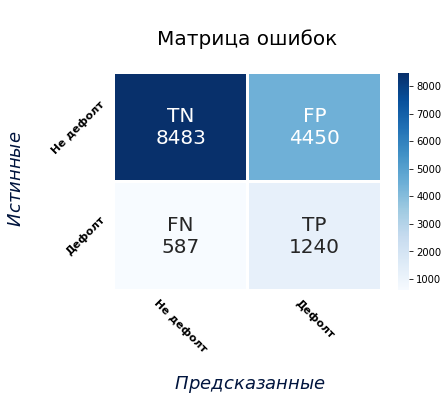

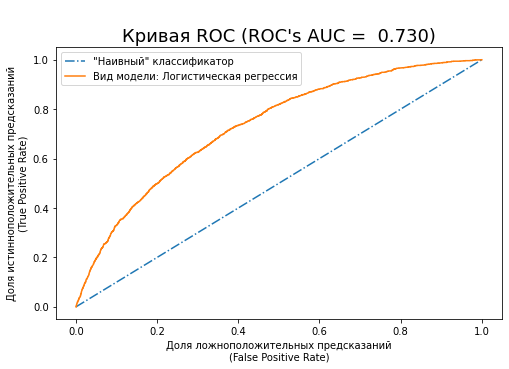

In [ ]:
model_metrics_WoE.print_metrics()
model_metrics_WoE.conf_matrix_visual()
model_metrics_WoE.plot_roc_curve(model_label='Логистическая регрессия')

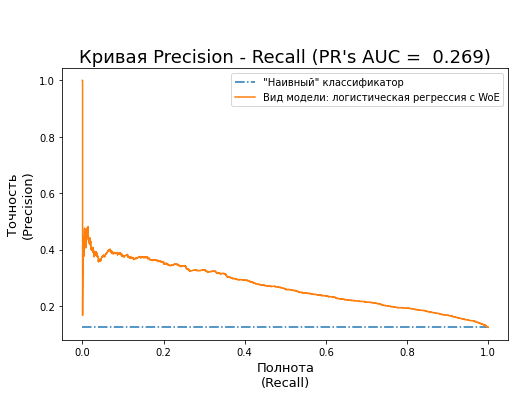

In [ ]:
model_metrics_WoE.plot_precision_recall_curve(model_label='логистическая регрессия с WoE')

##### Метод k ближайших соседей

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# реализуем метод k ближайших соседей
KNN_num = 3
KNN = KNeighborsClassifier(n_neighbors=KNN_num)
KNN.fit(X_train, y_train)

y_pred_knn = KNN.predict(X_valid)
y_proba_knn = KNN.predict_proba(X_valid)[:, 1]

Метрики для модели "K ближайших соседей"

In [ ]:
model_metrics_knn = ModelMetrics(y_valid, y_pred, y_proba)



===============================  МЕТРИКИ  ==============================



,Accuracy,Balanced accuracy,Precision,Recall,F1-score,ROC's AUC
,0.659282,0.666213,0.217637,0.675424,0.329198,0.73484


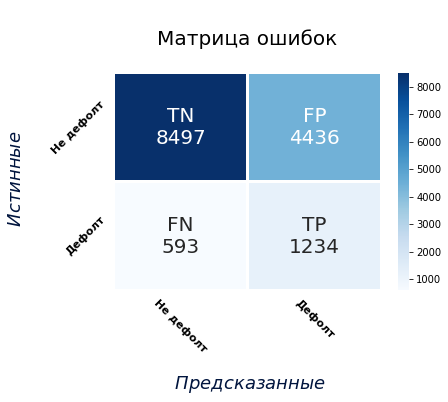

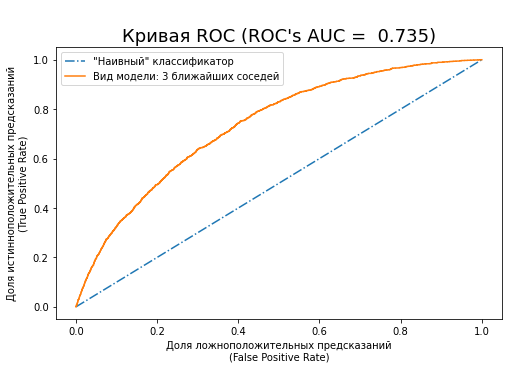

In [ ]:
model_metrics_knn.print_metrics()
model_metrics_knn.conf_matrix_visual()
model_metrics_knn.plot_roc_curve(model_label=f'{KNN_num} ближайших соседей')

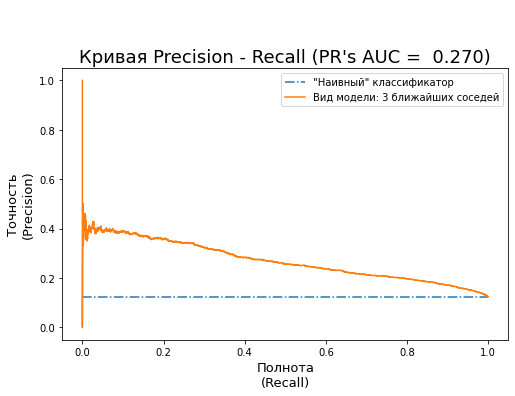

In [ ]:
model_metrics_knn.plot_precision_recall_curve(model_label=f'{KNN_num} ближайших соседей')

##### Решающие деревья

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_SEED)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_valid)
y_proba_tree = tree.predict_proba(X_valid)[:, 1]

Метрики для модели "Решающие деревья"

In [ ]:
model_metrics_tree = ModelMetrics(y_valid, y_pred_tree, y_proba_tree)



===============================  МЕТРИКИ  ==============================



,Accuracy,Balanced accuracy,Precision,Recall,F1-score,ROC's AUC
,0.798442,0.534346,0.184268,0.183361,0.183813,0.534346


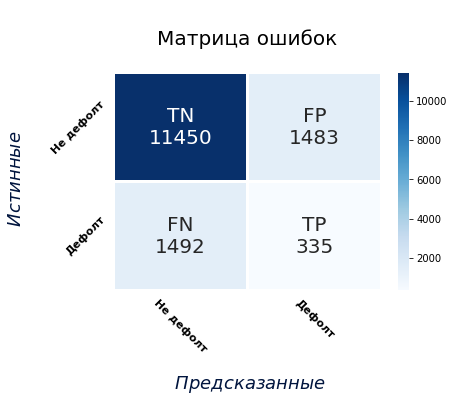

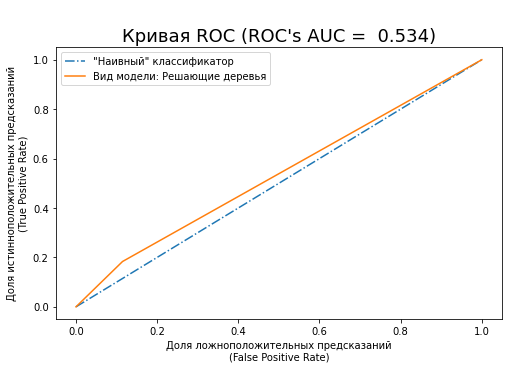

In [ ]:
model_metrics_tree.print_metrics()
model_metrics_tree.conf_matrix_visual()
model_metrics_tree.plot_roc_curve(model_label='Решающие деревья')

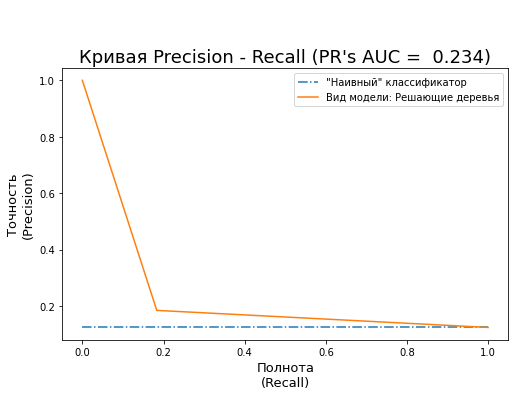

In [ ]:
model_metrics_tree.plot_precision_recall_curve(model_label='Решающие деревья')

---
## **6. Оптимизация гиперпараметров**
---
---

##### Логистическая регрессия

In [ ]:
from sklearn.model_selection import GridSearchCV

# инициализируем оптимизацию гиперпараметров GridSearch
model_opt = LogisticRegression(random_state = RANDOM_SEED)

iter_ = 1000
epsilon_stop = 1e-5
C = np.logspace(-3, 2, 5)

# определяем сетку параметров для оптимизации
param_grid = [
    {'C': C,
     'penalty': ['l1'], 
     'solver': ['liblinear'], 
     'class_weight':['balanced'], 
     'multi_class': ['ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'C': C,
     'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['balanced'], 
     'multi_class': ['ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight': ['balanced'], 
     'multi_class': ['ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]}
]

# запускаем оптимизацию
gridsearch = GridSearchCV(model_opt, param_grid, scoring='f1',
                          n_jobs=-1, cv=15, refit=True)
gridsearch.fit(X_valid, y_valid)
model_opt = gridsearch.best_estimator_

##печатаем параметры
best_parameters = model_opt.get_params()

for param_name in sorted(best_parameters.keys()):
        # print('\t%s: %r' % (param_name, best_parameters[param_name]))
        print(f'\t{param_name}: {best_parameters[param_name]}')

	C: 0.01778279410038923
	class_weight: balanced
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 1000
	multi_class: ovr
	n_jobs: None
	penalty: l1
	random_state: 42
	solver: liblinear
	tol: 1e-05
	verbose: 0
	warm_start: False


In [ ]:
y_pred_opt = model_opt.predict(X_valid)
y_proba_opt = model_opt.predict_proba(X_valid)[:, 1]

In [ ]:
model_metrics_opt = ModelMetrics(y_valid, y_pred_opt, y_proba_opt)



===============================  МЕТРИКИ  ==============================



,Accuracy,Balanced accuracy,Precision,Recall,F1-score,ROC's AUC
,0.670325,0.668284,0.222263,0.665572,0.333242,0.735043


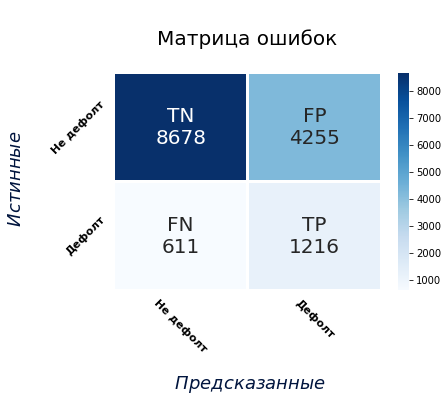

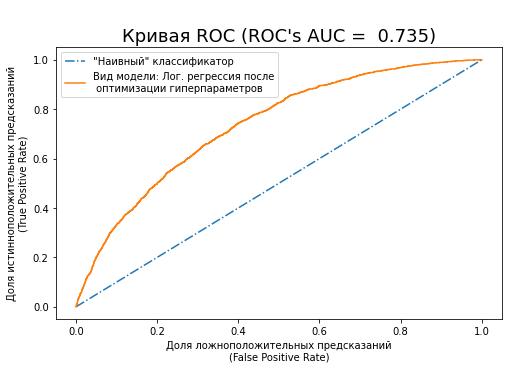

In [ ]:
model_metrics_opt.print_metrics()
model_metrics_opt.conf_matrix_visual()
model_metrics_opt.plot_roc_curve(model_label='Лог. регрессия после\n оптимизации гиперпараметров')

> **Вывод:** оптимизация гиперпараметров логистической регрессии не улучшила предсказательную силу модели

##### Логистическая регрессия **с WoE**

## **7. Отправка результатов**

In [ ]:
# predict_submission = logreg.predict(test_data)
predict_submission = logreg_WoE.predict(test_data_for_WoE)

In [ ]:
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

NameError: ignored

In [ ]:
# !kaggle competitions submit Timofey Akimkin -c sf-scoring -f submission.csv -m "Message"
# !kaggle competitions submit your-competition-name -f submission.csv -m 'My submission message'